In [1]:
import mglearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

# カーネル法を用いたサポートベクタマシン
カーネル法を用いたサポートベクタマシンとは、入力空間の超平面(重みとインプットの線形和で分類されるような平面)のような簡単なモデルではなく、より複雑なモデルを可能にするために線形サポートベクタマシンを拡張したものである。


低次元における線形モデルは非常に制約が強い。直線や超平面が柔軟性を制限するからだ。線形モデルを柔軟にする方法の一つが、特徴量を追加することである。例えば入力特徴量の交互作用項多項式項を加えることが考えられる

In [2]:
from sklearn.datasets import make_blobs

In [6]:
X, y = make_blobs(centers=4, random_state=8)
y = y % 2

Text(0,0.5,'Feature 1')

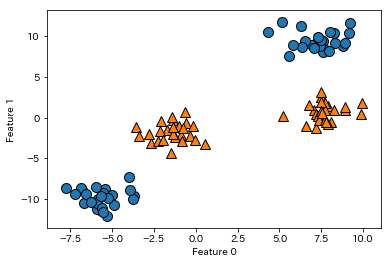

In [7]:
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')

線形モデルによるクラス分類では、直線で分類することしかできないので、このようなデータセットではうまくいかない

In [8]:
from sklearn.svm import LinearSVC
linear_svm = LinearSVC().fit(X, y)

Text(0,0.5,'Feature 1')

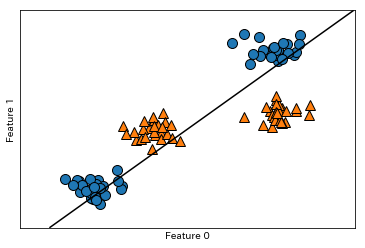

In [9]:
mglearn.plots.plot_2d_separator(linear_svm, X)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')

ここで入力特徴量を追加してみよう。例えば feature1 ** 2、つまり2番目の特徴量の2乗を新しい特徴量として追加する。

In [11]:
X_new = np.hstack([X, X[:, 1:]**2])

Text(0.5,0,'feature 1 ** 2')

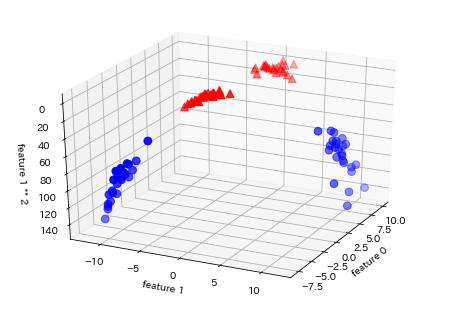

In [23]:
from mpl_toolkits.mplot3d import Axes3D, axes3d
figure = plt.figure()

#3D可視化
ax = Axes3D(figure, elev=-152, azim=-26)
# y==0の点をプロットしてから y==1の点をプロット
mask = y == 0
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b', cmap=mglearn.cm2, s=60)
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^', cmap=mglearn.cm2, s=60)
ax.set_xlabel('feature 0')
ax.set_ylabel('feature 1')
ax.set_zlabel('feature 1 ** 2')

この新しい表現では2つのクラスを線形モデルで、つまり3次元空間内の平面を用いて分離することが可能になっている。線形モデルを適用してみよう。

In [24]:
linear_svm_3d = LinearSVC().fit(X_new, y)
coef, intercept = linear_svm_3d.coef_.ravel(), linear_svm_3d.intercept_

Text(0.5,0,'feature1 ** 2')

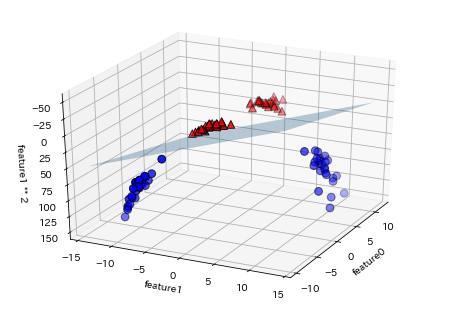

In [33]:
figure = plt.figure()
ax = Axes3D(figure, elev=-152, azim=-26)
xx = np.linspace(X_new[:, 0].min() - 2, X_new[:, 0].max() + 2, 50)
yy = np.linspace(X_new[:, 1].min() - 2, X_new[:, 1].max() + 2, 50)

XX, YY = np.meshgrid(xx, yy)
ZZ = (coef[0] * XX + coef[1] * YY + intercept) / -coef[2]
ax.plot_surface(XX, YY, ZZ, rstride=8, cstride=8, alpha=0.3)
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b',
           cmap=mglearn.cm2, s=60, edgecolor='k')
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^',
           cmap=mglearn.cm2, s=60, edgecolor='k')

ax.set_xlabel("feature0")
ax.set_ylabel("feature1")
ax.set_zlabel("feature1 ** 2")

もとの特徴量の関数としてみると、線形SVMは線形ではなく、楕円のような形になっている。

Text(0,0.5,'Feature 1')

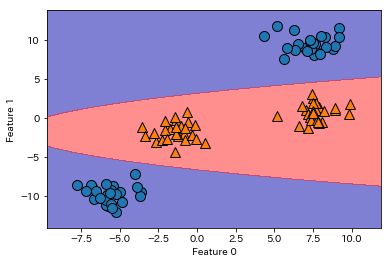

In [34]:
ZZ = YY ** 2
dec = linear_svm_3d.decision_function(np.c_[XX.ravel(), YY.ravel(), ZZ.ravel()])
plt.contourf(XX, YY, dec.reshape(XX.shape), levels=[dec.min(), 0, dec.max()],
             cmap=mglearn.cm2, alpha=0.5)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

## カーネルトリック
ここからわかるのは、非線形の特徴量をデータ表現に加えることによって、線形モデルは柔軟性がますということだ。しかし実際にはどの特徴量を加えたら良いかはわからない。たくさん加える(100次元の特徴量の積をすべて計算するとか)では計算量が多すぎる。  
カーネルトリックではそのような膨大になりうる計算を実際に計算せずに、高次元空間でのクラス分類器を学習させる巧妙な数学的トリックである。それは、拡張された特徴表現上でのデータポイントの距離を、実際にデータポイントの拡張の計算をせずに、直接計算する方法である。  


SVMで広く用いられている高次元空間へのマップ方法が2つある。
- 多項式カーネル(polynominal kernel): 元の特徴量の特定の次数までのすべての多項式を計算する。
- ガウシアンカーネル(別名:放射基底関数 radial basis function: RBF): 直感的にはすべての次数のすべての多項式を考えるが、次数が高くなるにつれてその特徴量の重要性を小さくする。

## SVM
訓練の過程で、SVMは個々のデータポイントが2つのクラスの決定境界を表現するのにどの程度重要かを学習する。多くの場合、2つのクラスの境界に位置するごく一部の訓練データポイントだけが決定境界を決定する。これらのデータポイントを**サポートベクタ(supprot vector)**と呼ぶ。これがサポートベクタマシンの由来である。

新しいデータポイントに対して予測を行う際に、サポートベクタとデータポイントの距離が測定される。クラス分類は、このサポートベクタとの距離と訓練過程で学習された個々のサポートベクタの重要性(SVMのdual_coef_属性に格納される)によって決定される。  
データポイントの間の距離は次のように定義されるガウシアンカーネルで測られる

\begin{equation}
     k_{rbf}(x_{1}, x_{2}) = exp(-\gamma \| x_{1} - x_{2} \|^{2})
\end{equation}

ここで$x_{1}$と$x_{2}$はデータポイントである。$\| x_{1} - x_{2} \|$はユークリッド距離を表し、$\gamma$はガウシアンカーネルの幅を制御するパラメータである。

Text(0,0.5,'Feature2')

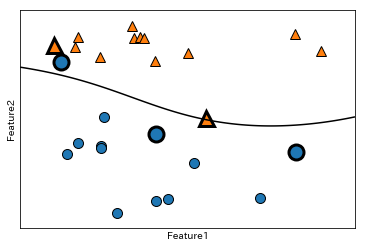

In [38]:
from sklearn.svm import SVC
X, y = mglearn.tools.make_handcrafted_dataset()
svm = SVC(kernel='rbf', C=10, gamma=0.1).fit(X, y)
mglearn.plots.plot_2d_separator(svm, X, eps=.5)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
#サポートベクタをプロットする
sv = svm.support_vectors_
#サポートベクタのクラスラベルはdeal_coef_の正負で与えられる
sv_labels = svm.dual_coef_.ravel() > 0
mglearn.discrete_scatter(sv[:, 0], sv[:, 1], sv_labels, s=15, markeredgewidth=3)
plt.xlabel('Feature1')
plt.ylabel('Feature2')

## SVMのパラメータ調整
gammaパラメータは、ガウシアンカーネルの幅を調節する。このパラメータが、点が近いということを意味するスケールを決定する。  
Cパラメータは、線形モデルで用いられた正則化項と同様のパラメータである。個々のデータポイントの重要度(より詳しく言うとデータポイントのdual_coef_)を制限する。これらのパラメータ制御による変化を検証してみよう。

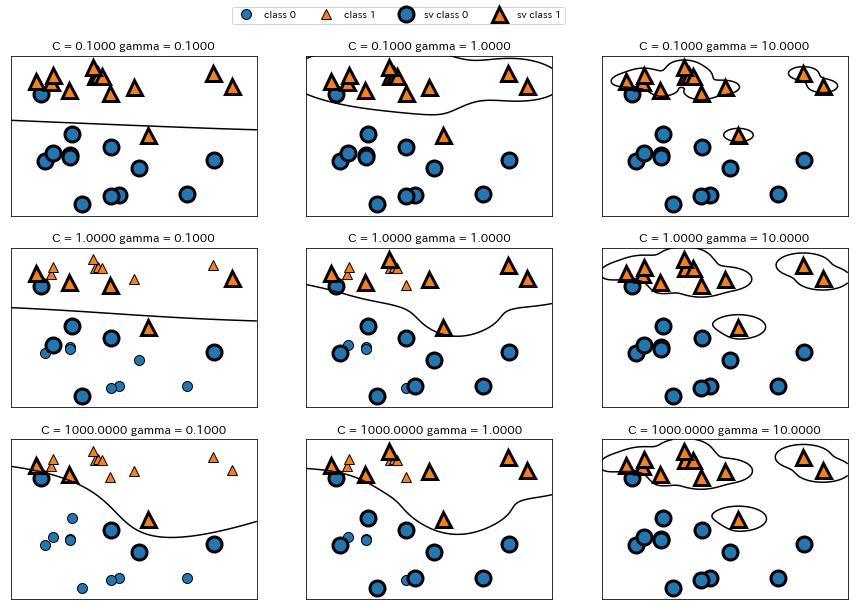

In [42]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

for ax, C in zip(axes, [-1, 0, 3]):
    for a, gamma, in zip(ax, range(-1, 2)):
        mglearn.plots.plot_svm(log_C=C, log_gamma=gamma, ax=a)
        
axes[0, 0].legend(['class 0', 'class 1', 'sv class 0', 'sv class 1'], ncol=4, loc=(.9, 1.2))